In [1]:
#@title download data and unzip it
!pip install gdown
!gdown https://drive.google.com/uc?id=1BZ7csn2S1ug_JH_H28U8P9uOw_1pd2IW
!unzip -q FIVES_512.zip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Downloading...
From (original): https://drive.google.com/uc?id=1BZ7csn2S1ug_JH_H28U8P9uOw_1pd2IW
From (redirected): https://drive.google.com/uc?id=1BZ7csn2S1ug_JH_H28U8P9uOw_1pd2IW&confirm=t&uuid=4afc0b51-ac44-4224-b431-b3271003141d
To: /home/mzmighty17/UNet/FIVES_512.zip
100%|████████████████████████████████████████| 211M/211M [00:18<00:00, 11.5MB/s]


In [3]:
# Define Model
from glob import glob
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

class UNet(nn.Module):
    # 입력이미지를 효과적으로 분할하여 각 픽셀의 클래스를 예측하는 모델
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes # 모델을 분류할 클래스의 수를 입력 받는다.
        # Encoding pathway
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 2*2 max plooling으로 down sampling하여 인코더의 다음단계로 아래 max pooling도 같음
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 중간 레이어 -> 가장 작은 피처 맵 크기에서 가장 많은 수의 피처를 추출
        self.middle = self.conv_block(in_channels=512, out_channels=1024)

        # Decoding pathway
        # ConvTranspose2d -> Upsampling -> 피처 맵의 크기를 증가시킨다.
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        # 컨볼루션 블록과 Upsampling된 피처 맵을 결합하여 더욱 정교한 피처 맵을 생성
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)

        # 출력 레이어
        self.output = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.output1 = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1, stride=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    # 순전파
    def forward(self, X):
        # 입력이미지를 단계별로 추출하면서 피처를 추출 
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]

        # 중간레이어를 거쳐서
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]

        # 피처를 확장 
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]

        # 최종 출력은 클래스별 확률 맵이다.
        output_out = self.output(expansive_42_out) # [-1, 64, 256, 256] -> [-1, 64, 256, 256]
        output_out1 = self.output1(output_out) # [-1, num_classes, 256, 256]

        return output_out1

In [30]:
class FIVESDataset(torch.utils.data.Dataset):
    def __init__(self,folder,transform=None):
        super().__init__()

        #이미지 파일 리스트 불러오기 
        img_files = sorted(glob(os.path.join(folder,'Original','*png')))
        label_files = sorted(glob(os.path.join(folder,'Ground truth','*png')))

        # 이미지 self.files 저장
        self.files = [img_files, label_files]

        # transform 저장
        self.transform = transform

    def __getitem__(self,index):
        # index에 해당하는 이미지를 읽어서, img_file, label_file 리턴
        imgs = [Image.open(self.files[0][index]), Image.open(self.files[1][index])]
        imgs = [self.transform(img) for img in imgs]
        return imgs
        
    def __len__(self):
        return len(self.files[0])

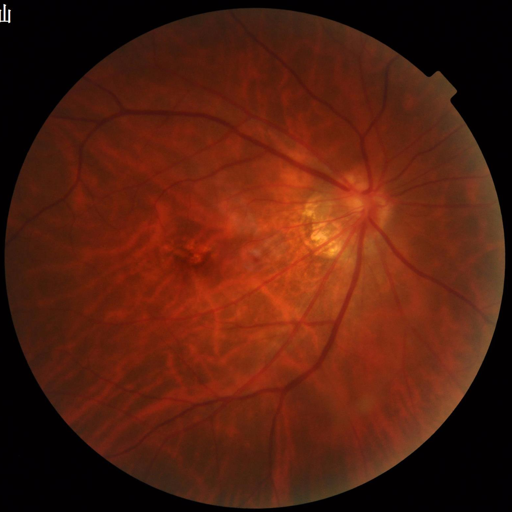

In [31]:
Image.open(img_files[0])

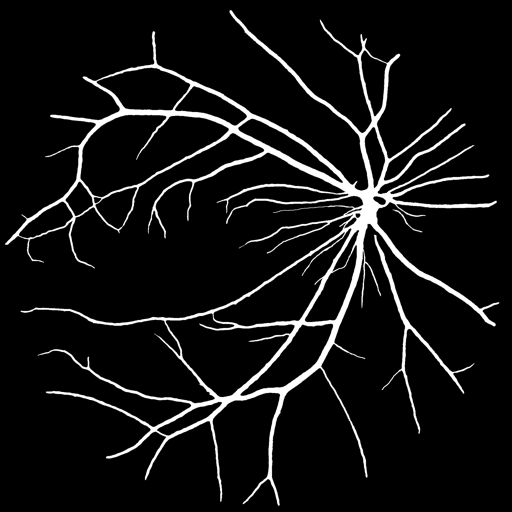

In [32]:
Image.open(label_files[0])

In [50]:
data_path = 'train/'
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor()])

dataset = FIVESDataset(data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, 16) # 왜 16?
item_test = iter(train_loader).__next__()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.5818
Epoch [2/50], Loss: 0.1750
Epoch [3/50], Loss: 0.1401
Epoch [4/50], Loss: 0.1270
Epoch [5/50], Loss: 0.1216
Epoch [6/50], Loss: 0.1153
Epoch [7/50], Loss: 0.1119
Epoch [8/50], Loss: 0.1090
Epoch [9/50], Loss: 0.1054
Epoch [10/50], Loss: 0.1022
Epoch [11/50], Loss: 0.0993
Epoch [12/50], Loss: 0.0972
Epoch [13/50], Loss: 0.0959
Epoch [14/50], Loss: 0.0949
Epoch [15/50], Loss: 0.0937
Epoch [16/50], Loss: 0.0922
Epoch [17/50], Loss: 0.0912
Epoch [18/50], Loss: 0.0900
Epoch [19/50], Loss: 0.0890
Epoch [20/50], Loss: 0.0882
Epoch [21/50], Loss: 0.0874
Epoch [22/50], Loss: 0.0866
Epoch [23/50], Loss: 0.0859
Epoch [24/50], Loss: 0.0854
Epoch [25/50], Loss: 0.0848
Epoch [26/50], Loss: 0.0844
Epoch [27/50], Loss: 0.0840
Epoch [28/50], Loss: 0.0838
Epoch [29/50], Loss: 0.0834
Epoch [30/50], Loss: 0.0833
Epoch [31/50], Loss: 0.0829
Epoch [32/50], Loss: 0.0828
Epoch [33/50], Loss: 0.0828
Epoch [34/50], Loss: 0.0824
Epoch [35/50], Loss: 0.0819
Epoch [36/50], Loss: 0.0815
E

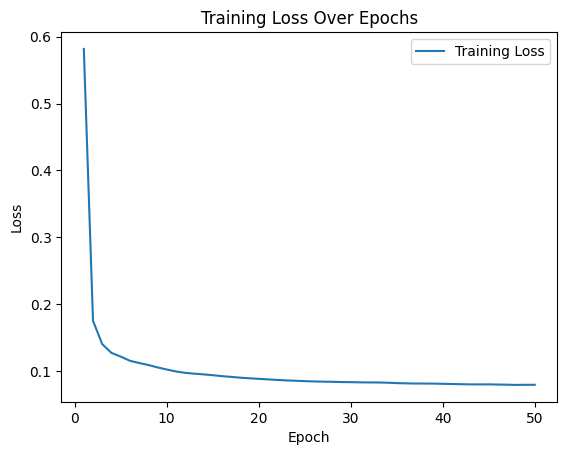

In [53]:
import matplotlib.pyplot as plt

device = 'cuda'
epochs = 50
net = UNet(1).to(device)  # 1: 모델의 출력 채널 수
criterion = nn.BCEWithLogitsLoss()  # 손실 함수
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)  # 옵티마이저와 학습률

loss_history = []  # 손실 값을 기록할 리스트

for epoch in tqdm(range(epochs)):
    net.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0  # 에포크당 손실을 추적하기 위한 변수
    
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()  # 이전 배치에서 계산된 변화도가 현재 배치에 누적되지 않도록 초기화
        pred = net(img)  # 모델에 입력 이미지를 전달하여 예측값 계산
        loss = criterion(pred, label)  # 손실 계산
        loss.backward()  # 손실 함수의 변화율을 계산하여 각 파라미터에 대한 그라디언트 계산
        optimizer.step()  # 파라미터 업데이트
        
        running_loss += loss.item()  # 현재 배치의 손실 값을 누적

    average_loss = running_loss / len(train_loader)  # 에포크당 평균 손실 계산
    loss_history.append(average_loss)  # 평균 손실 값을 기록
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}")  # 평균 손실 값 출력

print("Training complete.")

# 손실 변화 플롯
plt.figure()
plt.plot(range(1, epochs + 1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


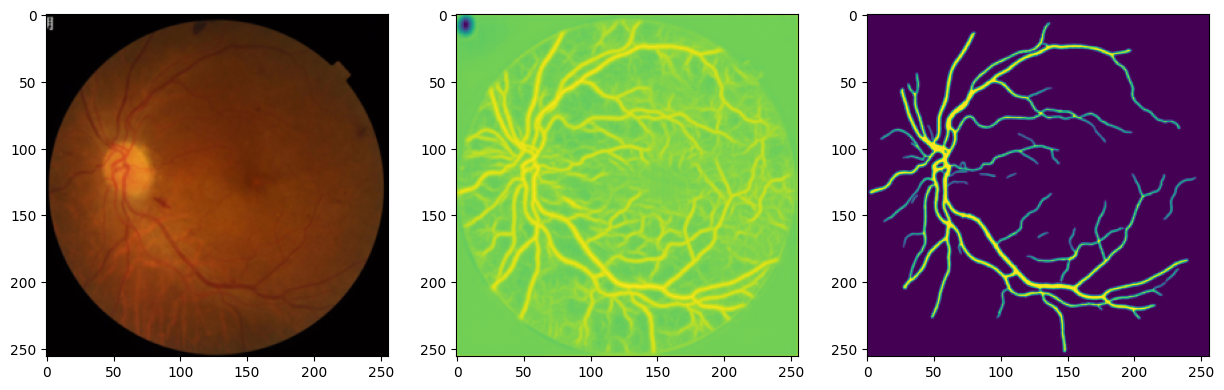

In [55]:
# Test
path = 'test/'
test_dataset = FIVESDataset(path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,1) # 왜 1?
item_test = iter(test_loader).__next__()

# 순전파 연산의 경우 연산 기록 추적 필요없음 -> 연산 추적 멈추기 
with torch.no_grad():
    img, label = item_test
    img = img.to(device)
    label = label.to(device)
    output = net(img)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(np.transpose(img.squeeze(0).detach().cpu().numpy(), [1,2,0])) # 입력 이미지
axes[1].imshow(np.transpose(output.squeeze(0).detach().cpu().numpy(), [1,2,0])) # 모델 예측 결과
axes[2].imshow(np.transpose(label.squeeze(0).detach().cpu().numpy(), [1,2,0])) # 실제 라벨 이미지
plt.show()

In [56]:
# test 데이터셋을 이용해 어느 정도의 정확도를 보이는지 확인
# accuracy, recall, precision, f1-score
precisions, recalls, f1_scores, accuracies = [], [], [], []
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        pred = net(img)
        pred = torch.where(F.sigmoid(pred) > 0.5, 1.0, 0)
        label = torch.where(label > 0.5, 1.0, 0)

        # Precision, Recall, F1 Score 계산
        precision = float(torch.sum(pred * label)) / (float(torch.sum(pred)) + 1)
        recall = float(torch.sum(pred * label)) / (float(torch.sum(label)) + 1)
        f1_score = 2.0 * precision * recall / (precision + recall + 1e-8)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)

        # Accuracy 계산
        correct = torch.sum(pred == label).item()
        total = torch.numel(pred)
        accuracy = correct / total
        accuracies.append(accuracy)

print("Precision:", np.mean(precisions))
print("Recall:", np.mean(recalls))
print("F1 Score:", np.mean(f1_scores))
print("Accuracy:", np.mean(accuracies))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Precision: 0.9465418161317847
Recall: 0.5959285916279203
F1 Score: 0.7217813698009361
Accuracy: 0.9690377044677735


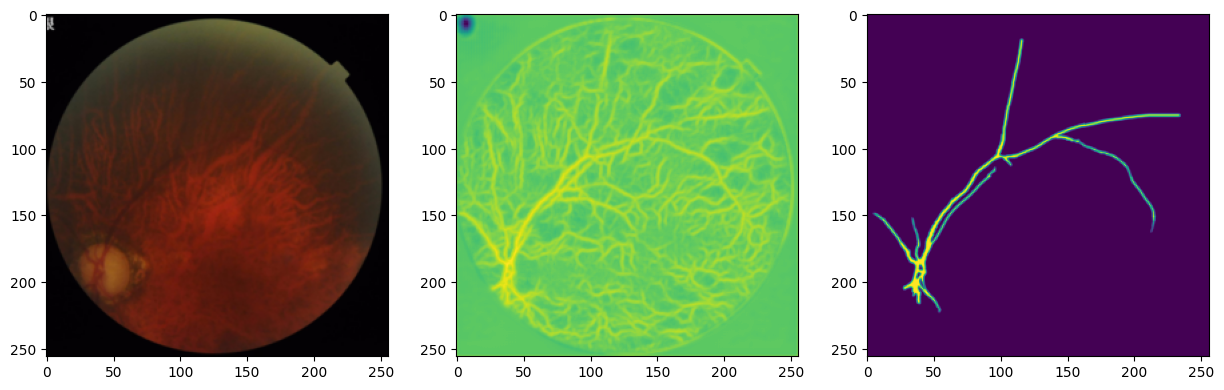

In [58]:
# Save & Load
# 저장된 모델을 불러와서 다시 동일한 결과가 나오는지 확인해보자

torch.save(net.state_dict(), "UNet.pth")
net = UNet(1).to(device)
net.load_state_dict(torch.load("UNet.pth"))

data_path = 'test/'
test_dataset = FIVESDataset(data_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, 1)
loaded = iter(test_loader)
[loaded.__next__() for _ in range(20)]
item_test = loaded.__next__()

with torch.no_grad():
    img, label = item_test
    img, label = img.to(device), label.to(device)
    output = net(img)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(np.transpose(img.squeeze(0).detach().cpu().numpy(), [1,2,0]))
axes[1].imshow(np.transpose(output.squeeze(0).detach().cpu().numpy(), [1,2,0]))
axes[2].imshow(np.transpose(label.squeeze(0).detach().cpu().numpy(), [1,2,0]))
plt.show()

In [59]:
precisions, recalls, f1_scores, accuracies = [], [], [], []
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        pred = net(img)
        pred = torch.where(F.sigmoid(pred) > 0.5, 1.0, 0)
        label = torch.where(label > 0.5, 1.0, 0)

        # Precision, Recall, F1 Score 계산
        precision = float(torch.sum(pred * label)) / (float(torch.sum(pred)) + 1)
        recall = float(torch.sum(pred * label)) / (float(torch.sum(label)) + 1)
        f1_score = 2.0 * precision * recall / (precision + recall + 1e-8)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)

        # Accuracy 계산
        correct = torch.sum(pred == label).item()
        total = torch.numel(pred)
        accuracy = correct / total
        accuracies.append(accuracy)

print("Precision:", np.mean(precisions))
print("Recall:", np.mean(recalls))
print("F1 Score:", np.mean(f1_scores))
print("Accuracy:", np.mean(accuracies))

Precision: 0.9465417960716488
Recall: 0.5959274785379827
F1 Score: 0.7217805621331741
Accuracy: 0.9690376281738281
